In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[0]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Yang2024.csv', index_col=0)

data_df['choice'] = data_df['choice'].map({1:0, 2:1})
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(tr_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                            "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

obs_test = np.asarray(ts_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(ts_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                           "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

print(X_train.shape, X_test.shape)

(6804, 8) (2927, 8)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 8
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 96        
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=2500)

Epoch 1/2500
1/1 [==============================] - 1s 610ms/step - loss: 32269.3184
Epoch 2/2500
1/1 [==============================] - 0s 3ms/step - loss: 32121.6016
Epoch 3/2500
1/1 [==============================] - 0s 3ms/step - loss: 32019.3809
Epoch 4/2500
1/1 [==============================] - 0s 3ms/step - loss: 31935.6875
Epoch 5/2500
1/1 [==============================] - 0s 3ms/step - loss: 31862.6133
Epoch 6/2500
1/1 [==============================] - 0s 10ms/step - loss: 31796.5215
Epoch 7/2500
1/1 [==============================] - 0s 5ms/step - loss: 31735.4277
Epoch 8/2500
1/1 [==============================] - 0s 5ms/step - loss: 31678.0938
Epoch 9/2500
1/1 [==============================] - 0s 6ms/step - loss: 31623.6934
Epoch 10/2500
1/1 [==============================] - 0s 5ms/step - loss: 31571.6582
Epoch 11/2500
1/1 [==============================] - 0s 6ms/step - loss: 31521.5703
Epoch 12/2500
1/1 [==============================] - 0s 5ms/step - loss: 31473.093

1/1 [==============================] - 0s 4ms/step - loss: 28346.0781
Epoch 99/2500
1/1 [==============================] - 0s 4ms/step - loss: 28315.2148
Epoch 100/2500
1/1 [==============================] - 0s 5ms/step - loss: 28284.4824
Epoch 101/2500
1/1 [==============================] - 0s 4ms/step - loss: 28253.8750
Epoch 102/2500
1/1 [==============================] - 0s 4ms/step - loss: 28223.3867
Epoch 103/2500
1/1 [==============================] - 0s 4ms/step - loss: 28193.0137
Epoch 104/2500
1/1 [==============================] - 0s 4ms/step - loss: 28162.7598
Epoch 105/2500
1/1 [==============================] - 0s 4ms/step - loss: 28132.6230
Epoch 106/2500
1/1 [==============================] - 0s 4ms/step - loss: 28102.5977
Epoch 107/2500
1/1 [==============================] - 0s 4ms/step - loss: 28072.6914
Epoch 108/2500
1/1 [==============================] - 0s 4ms/step - loss: 28042.9043
Epoch 109/2500
1/1 [==============================] - 0s 4ms/step - loss: 28013.2

1/1 [==============================] - 0s 5ms/step - loss: 25816.0469
Epoch 195/2500
1/1 [==============================] - 0s 4ms/step - loss: 25792.8945
Epoch 196/2500
1/1 [==============================] - 0s 4ms/step - loss: 25769.7793
Epoch 197/2500
1/1 [==============================] - 0s 4ms/step - loss: 25746.6953
Epoch 198/2500
1/1 [==============================] - 0s 4ms/step - loss: 25723.6445
Epoch 199/2500
1/1 [==============================] - 0s 3ms/step - loss: 25700.6211
Epoch 200/2500
1/1 [==============================] - 0s 4ms/step - loss: 25677.6270
Epoch 201/2500
1/1 [==============================] - 0s 4ms/step - loss: 25654.6621
Epoch 202/2500
1/1 [==============================] - 0s 4ms/step - loss: 25631.7246
Epoch 203/2500
1/1 [==============================] - 0s 4ms/step - loss: 25608.8164
Epoch 204/2500
1/1 [==============================] - 0s 5ms/step - loss: 25585.9355
Epoch 205/2500
1/1 [==============================] - 0s 5ms/step - loss: 25563.

1/1 [==============================] - 0s 3ms/step - loss: 23676.9141
Epoch 291/2500
1/1 [==============================] - 0s 4ms/step - loss: 23655.1543
Epoch 292/2500
1/1 [==============================] - 0s 4ms/step - loss: 23633.4395
Epoch 293/2500
1/1 [==============================] - 0s 3ms/step - loss: 23611.7207
Epoch 294/2500
1/1 [==============================] - 0s 5ms/step - loss: 23590.0410
Epoch 295/2500
1/1 [==============================] - 0s 4ms/step - loss: 23568.3594
Epoch 296/2500
1/1 [==============================] - 0s 3ms/step - loss: 23546.7246
Epoch 297/2500
1/1 [==============================] - 0s 4ms/step - loss: 23525.0859
Epoch 298/2500
1/1 [==============================] - 0s 3ms/step - loss: 23503.4941
Epoch 299/2500
1/1 [==============================] - 0s 4ms/step - loss: 23481.9023
Epoch 300/2500
1/1 [==============================] - 0s 4ms/step - loss: 23460.3594
Epoch 301/2500
1/1 [==============================] - 0s 4ms/step - loss: 23438.

1/1 [==============================] - 0s 4ms/step - loss: 21763.6465
Epoch 387/2500
1/1 [==============================] - 0s 4ms/step - loss: 21746.0566
Epoch 388/2500
1/1 [==============================] - 0s 4ms/step - loss: 21728.5312
Epoch 389/2500
1/1 [==============================] - 0s 4ms/step - loss: 21711.0312
Epoch 390/2500
1/1 [==============================] - 0s 4ms/step - loss: 21693.5840
Epoch 391/2500
1/1 [==============================] - 0s 4ms/step - loss: 21676.1719
Epoch 392/2500
1/1 [==============================] - 0s 4ms/step - loss: 21658.8105
Epoch 393/2500
1/1 [==============================] - 0s 4ms/step - loss: 21641.4766
Epoch 394/2500
1/1 [==============================] - 0s 3ms/step - loss: 21624.1992
Epoch 395/2500
1/1 [==============================] - 0s 4ms/step - loss: 21606.9492
Epoch 396/2500
1/1 [==============================] - 0s 4ms/step - loss: 21589.7520
Epoch 397/2500
1/1 [==============================] - 0s 4ms/step - loss: 21572.

1/1 [==============================] - 0s 3ms/step - loss: 20235.8633
Epoch 483/2500
1/1 [==============================] - 0s 3ms/step - loss: 20221.4023
Epoch 484/2500
1/1 [==============================] - 0s 4ms/step - loss: 20206.9238
Epoch 485/2500
1/1 [==============================] - 0s 3ms/step - loss: 20192.5176
Epoch 486/2500
1/1 [==============================] - 0s 4ms/step - loss: 20178.0820
Epoch 487/2500
1/1 [==============================] - 0s 3ms/step - loss: 20163.7305
Epoch 488/2500
1/1 [==============================] - 0s 4ms/step - loss: 20149.3457
Epoch 489/2500
1/1 [==============================] - 0s 3ms/step - loss: 20135.0430
Epoch 490/2500
1/1 [==============================] - 0s 3ms/step - loss: 20120.7070
Epoch 491/2500
1/1 [==============================] - 0s 3ms/step - loss: 20106.4570
Epoch 492/2500
1/1 [==============================] - 0s 3ms/step - loss: 20092.1660
Epoch 493/2500
1/1 [==============================] - 0s 3ms/step - loss: 20077.

1/1 [==============================] - 0s 3ms/step - loss: 18953.9531
Epoch 579/2500
1/1 [==============================] - 0s 4ms/step - loss: 18941.7773
Epoch 580/2500
1/1 [==============================] - 0s 3ms/step - loss: 18929.4492
Epoch 581/2500
1/1 [==============================] - 0s 3ms/step - loss: 18917.3203
Epoch 582/2500
1/1 [==============================] - 0s 4ms/step - loss: 18905.0312
Epoch 583/2500
1/1 [==============================] - 0s 3ms/step - loss: 18892.9453
Epoch 584/2500
1/1 [==============================] - 0s 3ms/step - loss: 18880.6992
Epoch 585/2500
1/1 [==============================] - 0s 3ms/step - loss: 18868.6562
Epoch 586/2500
1/1 [==============================] - 0s 4ms/step - loss: 18856.4492
Epoch 587/2500
1/1 [==============================] - 0s 4ms/step - loss: 18844.4531
Epoch 588/2500
1/1 [==============================] - 0s 3ms/step - loss: 18832.2891
Epoch 589/2500
1/1 [==============================] - 0s 3ms/step - loss: 18820.

1/1 [==============================] - 0s 3ms/step - loss: 17868.8164
Epoch 675/2500
1/1 [==============================] - 0s 3ms/step - loss: 17858.5488
Epoch 676/2500
1/1 [==============================] - 0s 4ms/step - loss: 17848.0684
Epoch 677/2500
1/1 [==============================] - 0s 3ms/step - loss: 17837.8398
Epoch 678/2500
1/1 [==============================] - 0s 3ms/step - loss: 17827.3984
Epoch 679/2500
1/1 [==============================] - 0s 3ms/step - loss: 17817.2051
Epoch 680/2500
1/1 [==============================] - 0s 4ms/step - loss: 17806.7988
Epoch 681/2500
1/1 [==============================] - 0s 4ms/step - loss: 17796.6406
Epoch 682/2500
1/1 [==============================] - 0s 3ms/step - loss: 17786.2695
Epoch 683/2500
1/1 [==============================] - 0s 3ms/step - loss: 17776.1504
Epoch 684/2500
1/1 [==============================] - 0s 4ms/step - loss: 17765.8125
Epoch 685/2500
1/1 [==============================] - 0s 4ms/step - loss: 17755.

1/1 [==============================] - 0s 4ms/step - loss: 16949.4121
Epoch 771/2500
1/1 [==============================] - 0s 4ms/step - loss: 16940.7793
Epoch 772/2500
1/1 [==============================] - 0s 4ms/step - loss: 16931.7812
Epoch 773/2500
1/1 [==============================] - 0s 4ms/step - loss: 16923.1758
Epoch 774/2500
1/1 [==============================] - 0s 3ms/step - loss: 16914.1953
Epoch 775/2500
1/1 [==============================] - 0s 4ms/step - loss: 16905.6250
Epoch 776/2500
1/1 [==============================] - 0s 3ms/step - loss: 16896.6719
Epoch 777/2500
1/1 [==============================] - 0s 3ms/step - loss: 16888.1289
Epoch 778/2500
1/1 [==============================] - 0s 3ms/step - loss: 16879.2031
Epoch 779/2500
1/1 [==============================] - 0s 4ms/step - loss: 16870.6875
Epoch 780/2500
1/1 [==============================] - 0s 3ms/step - loss: 16861.7871
Epoch 781/2500
1/1 [==============================] - 0s 4ms/step - loss: 16853.

1/1 [==============================] - 0s 4ms/step - loss: 16157.1504
Epoch 867/2500
1/1 [==============================] - 0s 4ms/step - loss: 16149.6699
Epoch 868/2500
1/1 [==============================] - 0s 4ms/step - loss: 16141.6543
Epoch 869/2500
1/1 [==============================] - 0s 4ms/step - loss: 16134.1914
Epoch 870/2500
1/1 [==============================] - 0s 4ms/step - loss: 16126.1836
Epoch 871/2500
1/1 [==============================] - 0s 4ms/step - loss: 16118.7373
Epoch 872/2500
1/1 [==============================] - 0s 4ms/step - loss: 16110.7598
Epoch 873/2500
1/1 [==============================] - 0s 4ms/step - loss: 16103.3271
Epoch 874/2500
1/1 [==============================] - 0s 3ms/step - loss: 16095.3652
Epoch 875/2500
1/1 [==============================] - 0s 3ms/step - loss: 16087.9521
Epoch 876/2500
1/1 [==============================] - 0s 3ms/step - loss: 16080.0078
Epoch 877/2500
1/1 [==============================] - 0s 4ms/step - loss: 16072.

1/1 [==============================] - 0s 3ms/step - loss: 15440.1533
Epoch 963/2500
1/1 [==============================] - 0s 4ms/step - loss: 15432.9258
Epoch 964/2500
1/1 [==============================] - 0s 3ms/step - loss: 15425.3867
Epoch 965/2500
1/1 [==============================] - 0s 3ms/step - loss: 15418.1650
Epoch 966/2500
1/1 [==============================] - 0s 3ms/step - loss: 15410.6318
Epoch 967/2500
1/1 [==============================] - 0s 4ms/step - loss: 15403.3828
Epoch 968/2500
1/1 [==============================] - 0s 3ms/step - loss: 15395.8545
Epoch 969/2500
1/1 [==============================] - 0s 3ms/step - loss: 15388.6006
Epoch 970/2500
1/1 [==============================] - 0s 3ms/step - loss: 15381.0762
Epoch 971/2500
1/1 [==============================] - 0s 3ms/step - loss: 15373.7930
Epoch 972/2500
1/1 [==============================] - 0s 3ms/step - loss: 15366.2607
Epoch 973/2500
1/1 [==============================] - 0s 4ms/step - loss: 15358.

1/1 [==============================] - 0s 3ms/step - loss: 14737.3828
Epoch 1058/2500
1/1 [==============================] - 0s 4ms/step - loss: 14733.4072
Epoch 1059/2500
1/1 [==============================] - 0s 4ms/step - loss: 14729.6406
Epoch 1060/2500
1/1 [==============================] - 0s 3ms/step - loss: 14724.5117
Epoch 1061/2500
1/1 [==============================] - 0s 3ms/step - loss: 14715.5029
Epoch 1062/2500
1/1 [==============================] - 0s 4ms/step - loss: 14705.9717
Epoch 1063/2500
1/1 [==============================] - 0s 3ms/step - loss: 14696.0684
Epoch 1064/2500
1/1 [==============================] - 0s 3ms/step - loss: 14688.0518
Epoch 1065/2500
1/1 [==============================] - 0s 3ms/step - loss: 14681.9434
Epoch 1066/2500
1/1 [==============================] - 0s 4ms/step - loss: 14676.5859
Epoch 1067/2500
1/1 [==============================] - 0s 3ms/step - loss: 14671.3086
Epoch 1068/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 14107.4775
Epoch 1153/2500
1/1 [==============================] - 0s 3ms/step - loss: 14101.3955
Epoch 1154/2500
1/1 [==============================] - 0s 4ms/step - loss: 14095.1309
Epoch 1155/2500
1/1 [==============================] - 0s 3ms/step - loss: 14089.0098
Epoch 1156/2500
1/1 [==============================] - 0s 3ms/step - loss: 14082.7686
Epoch 1157/2500
1/1 [==============================] - 0s 3ms/step - loss: 14076.6982
Epoch 1158/2500
1/1 [==============================] - 0s 4ms/step - loss: 14070.4922
Epoch 1159/2500
1/1 [==============================] - 0s 4ms/step - loss: 14064.4160
Epoch 1160/2500
1/1 [==============================] - 0s 3ms/step - loss: 14058.2520
Epoch 1161/2500
1/1 [==============================] - 0s 3ms/step - loss: 14052.2031
Epoch 1162/2500
1/1 [==============================] - 0s 3ms/step - loss: 14046.0771
Epoch 1163/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 13571.0840
Epoch 1248/2500
1/1 [==============================] - 0s 4ms/step - loss: 13567.0078
Epoch 1249/2500
1/1 [==============================] - 0s 3ms/step - loss: 13560.8955
Epoch 1250/2500
1/1 [==============================] - 0s 3ms/step - loss: 13556.9033
Epoch 1251/2500
1/1 [==============================] - 0s 4ms/step - loss: 13550.9121
Epoch 1252/2500
1/1 [==============================] - 0s 4ms/step - loss: 13546.9961
Epoch 1253/2500
1/1 [==============================] - 0s 3ms/step - loss: 13540.9404
Epoch 1254/2500
1/1 [==============================] - 0s 4ms/step - loss: 13537.0938
Epoch 1255/2500
1/1 [==============================] - 0s 4ms/step - loss: 13531.0225
Epoch 1256/2500
1/1 [==============================] - 0s 4ms/step - loss: 13527.1465
Epoch 1257/2500
1/1 [==============================] - 0s 3ms/step - loss: 13521.1777
Epoch 1258/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 13147.9727
Epoch 1343/2500
1/1 [==============================] - 0s 5ms/step - loss: 13140.4629
Epoch 1344/2500
1/1 [==============================] - 0s 5ms/step - loss: 13139.9346
Epoch 1345/2500
1/1 [==============================] - 0s 4ms/step - loss: 13132.6729
Epoch 1346/2500
1/1 [==============================] - 0s 4ms/step - loss: 13132.2344
Epoch 1347/2500
1/1 [==============================] - 0s 5ms/step - loss: 13124.9141
Epoch 1348/2500
1/1 [==============================] - 0s 4ms/step - loss: 13124.5000
Epoch 1349/2500
1/1 [==============================] - 0s 4ms/step - loss: 13117.0469
Epoch 1350/2500
1/1 [==============================] - 0s 4ms/step - loss: 13116.7051
Epoch 1351/2500
1/1 [==============================] - 0s 5ms/step - loss: 13109.5791
Epoch 1352/2500
1/1 [==============================] - 0s 4ms/step - loss: 13109.4199
Epoch 1353/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 12808.4375
Epoch 1438/2500
1/1 [==============================] - 0s 3ms/step - loss: 12811.4316
Epoch 1439/2500
1/1 [==============================] - 0s 3ms/step - loss: 12807.0098
Epoch 1440/2500
1/1 [==============================] - 0s 3ms/step - loss: 12812.8223
Epoch 1441/2500
1/1 [==============================] - 0s 4ms/step - loss: 12805.0391
Epoch 1442/2500
1/1 [==============================] - 0s 3ms/step - loss: 12809.9229
Epoch 1443/2500
1/1 [==============================] - 0s 3ms/step - loss: 12800.9512
Epoch 1444/2500
1/1 [==============================] - 0s 4ms/step - loss: 12804.7158
Epoch 1445/2500
1/1 [==============================] - 0s 4ms/step - loss: 12792.7363
Epoch 1446/2500
1/1 [==============================] - 0s 4ms/step - loss: 12795.1074
Epoch 1447/2500
1/1 [==============================] - 0s 4ms/step - loss: 12784.8799
Epoch 1448/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 12562.5186
Epoch 1533/2500
1/1 [==============================] - 0s 4ms/step - loss: 12552.7920
Epoch 1534/2500
1/1 [==============================] - 0s 3ms/step - loss: 12563.0967
Epoch 1535/2500
1/1 [==============================] - 0s 3ms/step - loss: 12603.5312
Epoch 1536/2500
1/1 [==============================] - 0s 4ms/step - loss: 12565.1318
Epoch 1537/2500
1/1 [==============================] - 0s 3ms/step - loss: 12554.5811
Epoch 1538/2500
1/1 [==============================] - 0s 3ms/step - loss: 12562.5703
Epoch 1539/2500
1/1 [==============================] - 0s 3ms/step - loss: 12550.2246
Epoch 1540/2500
1/1 [==============================] - 0s 4ms/step - loss: 12555.5391
Epoch 1541/2500
1/1 [==============================] - 0s 3ms/step - loss: 12540.6592
Epoch 1542/2500
1/1 [==============================] - 0s 8ms/step - loss: 12546.2402
Epoch 1543/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 12364.5898
Epoch 1628/2500
1/1 [==============================] - 0s 5ms/step - loss: 12374.2373
Epoch 1629/2500
1/1 [==============================] - 0s 6ms/step - loss: 12357.4746
Epoch 1630/2500
1/1 [==============================] - 0s 4ms/step - loss: 12368.0557
Epoch 1631/2500
1/1 [==============================] - 0s 4ms/step - loss: 12355.3711
Epoch 1632/2500
1/1 [==============================] - 0s 5ms/step - loss: 12366.6465
Epoch 1633/2500
1/1 [==============================] - 0s 6ms/step - loss: 12399.7871
Epoch 1634/2500
1/1 [==============================] - 0s 4ms/step - loss: 12362.8223
Epoch 1635/2500
1/1 [==============================] - 0s 6ms/step - loss: 12348.6172
Epoch 1636/2500
1/1 [==============================] - 0s 6ms/step - loss: 12360.4668
Epoch 1637/2500
1/1 [==============================] - 0s 5ms/step - loss: 12395.3086
Epoch 1638/2500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 12225.6660
Epoch 1723/2500
1/1 [==============================] - 0s 3ms/step - loss: 12253.1641
Epoch 1724/2500
1/1 [==============================] - 0s 4ms/step - loss: 12218.1387
Epoch 1725/2500
1/1 [==============================] - 0s 3ms/step - loss: 12245.8262
Epoch 1726/2500
1/1 [==============================] - 0s 4ms/step - loss: 12210.5176
Epoch 1727/2500
1/1 [==============================] - 0s 3ms/step - loss: 12198.2930
Epoch 1728/2500
1/1 [==============================] - 0s 4ms/step - loss: 12214.1543
Epoch 1729/2500
1/1 [==============================] - 0s 3ms/step - loss: 12249.3623
Epoch 1730/2500
1/1 [==============================] - 0s 4ms/step - loss: 12215.5527
Epoch 1731/2500
1/1 [==============================] - 0s 3ms/step - loss: 12244.2559
Epoch 1732/2500
1/1 [==============================] - 0s 4ms/step - loss: 12256.1680
Epoch 1733/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 12084.6260
Epoch 1818/2500
1/1 [==============================] - 0s 4ms/step - loss: 12110.8281
Epoch 1819/2500
1/1 [==============================] - 0s 4ms/step - loss: 12090.0869
Epoch 1820/2500
1/1 [==============================] - 0s 5ms/step - loss: 12106.5225
Epoch 1821/2500
1/1 [==============================] - 0s 6ms/step - loss: 12132.9072
Epoch 1822/2500
1/1 [==============================] - 0s 4ms/step - loss: 12098.6514
Epoch 1823/2500
1/1 [==============================] - 0s 5ms/step - loss: 12067.1191
Epoch 1824/2500
1/1 [==============================] - 0s 5ms/step - loss: 12080.9834
Epoch 1825/2500
1/1 [==============================] - 0s 5ms/step - loss: 12104.8457
Epoch 1826/2500
1/1 [==============================] - 0s 5ms/step - loss: 12073.7402
Epoch 1827/2500
1/1 [==============================] - 0s 5ms/step - loss: 12055.0371
Epoch 1828/2500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 11993.3350
Epoch 1913/2500
1/1 [==============================] - 0s 4ms/step - loss: 11975.1113
Epoch 1914/2500
1/1 [==============================] - 0s 4ms/step - loss: 11997.2354
Epoch 1915/2500
1/1 [==============================] - 0s 4ms/step - loss: 11971.9316
Epoch 1916/2500
1/1 [==============================] - 0s 4ms/step - loss: 11987.6094
Epoch 1917/2500
1/1 [==============================] - 0s 4ms/step - loss: 11969.9102
Epoch 1918/2500
1/1 [==============================] - 0s 4ms/step - loss: 11990.7168
Epoch 1919/2500
1/1 [==============================] - 0s 4ms/step - loss: 11968.8926
Epoch 1920/2500
1/1 [==============================] - 0s 4ms/step - loss: 11982.0791
Epoch 1921/2500
1/1 [==============================] - 0s 3ms/step - loss: 12016.4600
Epoch 1922/2500
1/1 [==============================] - 0s 4ms/step - loss: 11979.5801
Epoch 1923/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 11873.4688
Epoch 2008/2500
1/1 [==============================] - 0s 3ms/step - loss: 11892.8223
Epoch 2009/2500
1/1 [==============================] - 0s 3ms/step - loss: 11881.6660
Epoch 2010/2500
1/1 [==============================] - 0s 3ms/step - loss: 11903.8535
Epoch 2011/2500
1/1 [==============================] - 0s 4ms/step - loss: 11883.2266
Epoch 2012/2500
1/1 [==============================] - 0s 3ms/step - loss: 11901.9531
Epoch 2013/2500
1/1 [==============================] - 0s 3ms/step - loss: 11925.1777
Epoch 2014/2500
1/1 [==============================] - 0s 3ms/step - loss: 11893.0938
Epoch 2015/2500
1/1 [==============================] - 0s 4ms/step - loss: 11917.3867
Epoch 2016/2500
1/1 [==============================] - 0s 3ms/step - loss: 11886.3467
Epoch 2017/2500
1/1 [==============================] - 0s 3ms/step - loss: 11863.9609
Epoch 2018/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 11810.3193
Epoch 2103/2500
1/1 [==============================] - 0s 3ms/step - loss: 11841.5000
Epoch 2104/2500
1/1 [==============================] - 0s 3ms/step - loss: 11817.3623
Epoch 2105/2500
1/1 [==============================] - 0s 3ms/step - loss: 11798.3008
Epoch 2106/2500
1/1 [==============================] - 0s 3ms/step - loss: 11824.9297
Epoch 2107/2500
1/1 [==============================] - 0s 3ms/step - loss: 11798.3838
Epoch 2108/2500
1/1 [==============================] - 0s 3ms/step - loss: 11816.3896
Epoch 2109/2500
1/1 [==============================] - 0s 3ms/step - loss: 11795.9844
Epoch 2110/2500
1/1 [==============================] - 0s 3ms/step - loss: 11822.0645
Epoch 2111/2500
1/1 [==============================] - 0s 3ms/step - loss: 11843.9346
Epoch 2112/2500
1/1 [==============================] - 0s 3ms/step - loss: 11813.1650
Epoch 2113/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 11729.2500
Epoch 2198/2500
1/1 [==============================] - 0s 3ms/step - loss: 11690.8418
Epoch 2199/2500
1/1 [==============================] - 0s 3ms/step - loss: 11679.3652
Epoch 2200/2500
1/1 [==============================] - 0s 3ms/step - loss: 11707.1836
Epoch 2201/2500
1/1 [==============================] - 0s 3ms/step - loss: 11753.5029
Epoch 2202/2500
1/1 [==============================] - 0s 3ms/step - loss: 11745.0859
Epoch 2203/2500
1/1 [==============================] - 0s 3ms/step - loss: 11746.8604
Epoch 2204/2500
1/1 [==============================] - 0s 3ms/step - loss: 11784.9014
Epoch 2205/2500
1/1 [==============================] - 0s 3ms/step - loss: 11770.9258
Epoch 2206/2500
1/1 [==============================] - 0s 3ms/step - loss: 11854.7080
Epoch 2207/2500
1/1 [==============================] - 0s 4ms/step - loss: 11807.0352
Epoch 2208/2500
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 11713.8193
Epoch 2293/2500
1/1 [==============================] - 0s 4ms/step - loss: 11683.7930
Epoch 2294/2500
1/1 [==============================] - 0s 4ms/step - loss: 11699.8652
Epoch 2295/2500
1/1 [==============================] - 0s 4ms/step - loss: 11661.7041
Epoch 2296/2500
1/1 [==============================] - 0s 4ms/step - loss: 11674.6377
Epoch 2297/2500
1/1 [==============================] - 0s 4ms/step - loss: 11704.5898
Epoch 2298/2500
1/1 [==============================] - 0s 4ms/step - loss: 11671.7754
Epoch 2299/2500
1/1 [==============================] - 0s 4ms/step - loss: 11658.2979
Epoch 2300/2500
1/1 [==============================] - 0s 4ms/step - loss: 11693.0938
Epoch 2301/2500
1/1 [==============================] - 0s 5ms/step - loss: 11716.1055
Epoch 2302/2500
1/1 [==============================] - 0s 4ms/step - loss: 11706.7217
Epoch 2303/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 11670.3633
Epoch 2388/2500
1/1 [==============================] - 0s 4ms/step - loss: 11676.0654
Epoch 2389/2500
1/1 [==============================] - 0s 4ms/step - loss: 11603.3926
Epoch 2390/2500
1/1 [==============================] - 0s 4ms/step - loss: 11624.9570
Epoch 2391/2500
1/1 [==============================] - 0s 4ms/step - loss: 11589.3350
Epoch 2392/2500
1/1 [==============================] - 0s 4ms/step - loss: 11611.6162
Epoch 2393/2500
1/1 [==============================] - 0s 4ms/step - loss: 11574.8398
Epoch 2394/2500
1/1 [==============================] - 0s 4ms/step - loss: 11594.9932
Epoch 2395/2500
1/1 [==============================] - 0s 4ms/step - loss: 11590.9648
Epoch 2396/2500
1/1 [==============================] - 0s 4ms/step - loss: 11629.1738
Epoch 2397/2500
1/1 [==============================] - 0s 4ms/step - loss: 11626.1328
Epoch 2398/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 11584.3057
Epoch 2483/2500
1/1 [==============================] - 0s 5ms/step - loss: 11607.1602
Epoch 2484/2500
1/1 [==============================] - 0s 4ms/step - loss: 11632.8955
Epoch 2485/2500
1/1 [==============================] - 0s 5ms/step - loss: 11576.5742
Epoch 2486/2500
1/1 [==============================] - 0s 4ms/step - loss: 11618.4766
Epoch 2487/2500
1/1 [==============================] - 0s 4ms/step - loss: 11582.9727
Epoch 2488/2500
1/1 [==============================] - 0s 5ms/step - loss: 11598.0449
Epoch 2489/2500
1/1 [==============================] - 0s 4ms/step - loss: 11558.6836
Epoch 2490/2500
1/1 [==============================] - 0s 4ms/step - loss: 11631.5371
Epoch 2491/2500
1/1 [==============================] - 0s 5ms/step - loss: 11554.8164
Epoch 2492/2500
1/1 [==============================] - 0s 5ms/step - loss: 11572.8301
Epoch 2493/2500
1/1 [==============================] - 0s 4ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 522us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

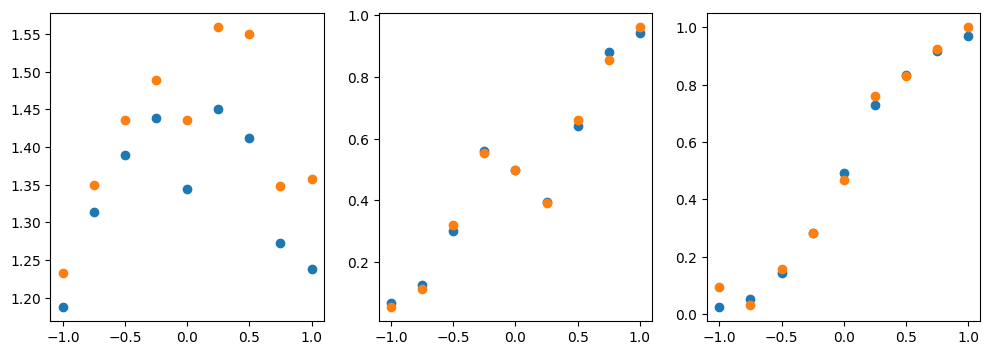

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

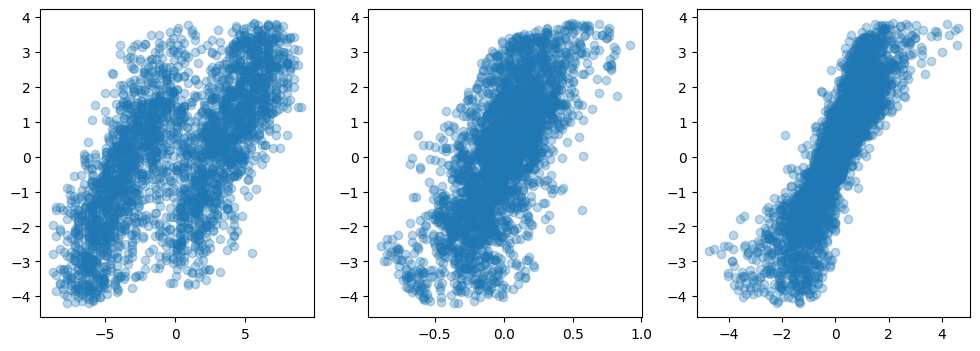

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] + X_test[:, 1] - X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 4] + X_test[:, 5] - X_test[:, 6] - X_test[:, 7], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
a1 = X_test[:, 0]*X_test[:, 4] +X_test[:, 1]*X_test[:, 5]
a2 = X_test[:, 2]*X_test[:, 6] +X_test[:, 3]*X_test[:, 7]
plt.scatter(a1 - a2, pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

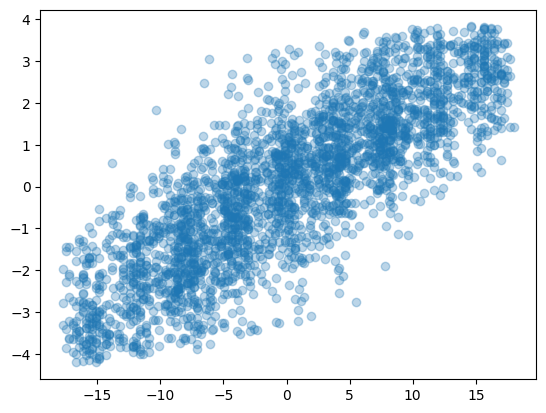

In [14]:
plt.scatter(4*X_test[:, 0] + X_test[:, 1] - 4*X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);